In [1]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

#### CUDA Initializations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('Using {} device'.format(device))

Using cpu device


#### Initializations

In [24]:
def plot_traj(cnt, traj_inp, traj_out, traj_pred, obs=[]):
    traj_inp = traj_inp.numpy()[:2*num]
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.detach().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(traj_inp[::2], traj_inp[1::2], label='Inp traj')
    ax.scatter(traj_out[:num], traj_out[num:], label='GT')
    ax.scatter(traj_pred[:num], traj_pred[num:], label='Pred')
#     ax.scatter(obs["x"], obs["y"], s=20, label="Obstacles")
    
#     x_obs_temp = obs["x"]
#     y_obs_temp = obs["y"]
    
#     th = np.linspace(0, 2 * np.pi, 100)
#     for i in range(0, num_obs):
#         x_circ = x_obs_temp[i] + a_obs * np.cos(th)
#         y_circ = y_obs_temp[i] + b_obs * np.sin(th)
#         ax.plot(x_circ, y_circ, '-k')
    
    ax.legend()
    plt.savefig('./results/{}.png'.format(cnt))
    plt.close()

In [3]:
t_fin = 2.0
num = 16

tot_time = np.linspace(0.0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
nvar = np.shape(P)[1]

In [4]:
A_eq_mat = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
A_eq_np = block_diag(A_eq_mat, A_eq_mat)
Q_np = 10 * block_diag(np.dot(Pddot.T, Pddot), np.dot(Pddot.T, Pddot))
q_np = np.zeros(2 * nvar)

#### QPNode

In [5]:
class QPNode(AbstractDeclarativeNode):
    def __init__(self, Q_np, q_np, A_eq_np, rho=1.0, nvar=22, maxiter=1000):
        super().__init__()
        self.rho = rho
        self.nvar = nvar
        self.maxiter = maxiter
        self.Q = torch.tensor(Q_np, dtype=torch.double).to(device)
        self.q = torch.tensor(q_np, dtype=torch.double).to(device)
        self.A = torch.tensor(A_eq_np, dtype=torch.double).to(device)
    
    def objective(self, b, lamda, y):
        """
        b: (B x 12)
        lamda: (B x 22)
        y: (B x 22)
        """
        lamda = lamda.transpose(0, 1)
        y = y.transpose(0, 1)
        cost_mat = self.rho * torch.matmul(self.A.T, self.A) + self.Q
        lincost_mat = -self.rho * torch.matmul(b, self.A).T + self.q.view(-1, 1) - lamda
        f = 0.5 * torch.diag(torch.matmul(y.T, torch.matmul(cost_mat, y))) + torch.diag(torch.matmul(lincost_mat.T, y))
        return f
    
    def compute_augmented_lagrangian(self, b, lamda):
        """
        b: (12,)
        lamda: (22,)
        """
        cost_mat = self.rho * torch.matmul(self.A.T, self.A) + self.Q
        lincost_mat = -self.rho * torch.matmul(b, self.A).T + self.q - lamda
        lincost_mat = lincost_mat.view(-1, 1)
        sol, _ = torch.solve(lincost_mat, -cost_mat)
        sol = sol.view(-1)
        res = torch.matmul(self.A, sol) - b
        return sol, res
    
    def optimize(self, b, lamda):
        sol, res = self.compute_augmented_lagrangian(b, lamda)
        for i in range(0, self.maxiter):
            sol, res = self.compute_augmented_lagrangian(b, lamda)
            lamda -= self.rho * torch.matmul(self.A.T, res)
        return sol
    
    def solve(self, b, lamda):
        batch_size, _ = b.size()
        y = torch.zeros(batch_size, 22, dtype=torch.double).to(device)
        for i in range(batch_size):
            b_cur = b[i]
            lamda_cur = lamda[i]
            sol = self.optimize(b_cur, lamda_cur)
            y[i, :] = sol
        return y, None

#### PyTorch Declarative Function

In [6]:
class QPFunction(torch.autograd.Function):
    """Generic declarative autograd function.
    Defines the forward and backward functions. Saves all inputs and outputs,
    which may be memory-inefficient for the specific problem.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    """
    @staticmethod
    def forward(ctx, problem, *inputs):
        output, solve_ctx = torch.no_grad()(problem.solve)(*inputs)
        ctx.save_for_backward(output, *inputs)
        ctx.problem = problem
        ctx.solve_ctx = solve_ctx
        return output.clone()

    @staticmethod
    def backward(ctx, grad_output):
        output, *inputs = ctx.saved_tensors
        problem = ctx.problem
        solve_ctx = ctx.solve_ctx
        output.requires_grad = True
        inputs = tuple(inputs)
        grad_inputs = problem.gradient(*inputs, y=output, v=grad_output,
            ctx=solve_ctx)
        return (None, *grad_inputs)

#### PyTorch Declarative Layer

In [7]:
class DeclarativeLayer(torch.nn.Module):
    """Generic declarative layer.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    Usage:
        problem = <derived class of *DeclarativeNode>
        declarative_layer = DeclarativeLayer(problem)
        y = declarative_layer(x1, x2, ...)
    """
    def __init__(self, problem):
        super(DeclarativeLayer, self).__init__()
        self.problem = problem
        
    def forward(self, *inputs):
        return QPFunction.apply(self.problem, *inputs)

#### TrajNet

In [8]:
class TrajNet(nn.Module):
    def __init__(self, opt_layer, P, input_size=32, hidden_size=64, output_size=12, nvar=11, t_obs=8):
        super(TrajNet, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.opt_layer = opt_layer
        self.activation = nn.ReLU()
        self.mask = torch.tensor([[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]], dtype=torch.double).to(device)
#         self.mask = torch.tensor([[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]], dtype=torch.double).to(device)
    
    def forward(self, x, b):
        batch_size, _ = x.size()
        out = self.activation(self.linear1(x))
        b_pred = self.linear2(out)
        b_gen = self.mask * b + (1 - self.mask) * b_pred
        
        # Run optimization
        lamda = torch.zeros(batch_size, 2 * self.nvar, dtype=torch.double).to(device)
        sol = self.opt_layer(b_gen, lamda)
        
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:].transpose(0, 1))
        
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
        out = torch.cat([x_pred, y_pred], dim=1)
        return out

#### Trajectory Data loader

In [9]:
class TrajectoryDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125):
        self.data = np.load(data_path)
        self.t_obs = t_obs
        self.dt = dt
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
        vx_traj = traj[:, 2]
        vy_traj = traj[:, 3]
        
        x_traj = x_traj - x_traj[0]
        y_traj = y_traj - y_traj[0]
        
        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
        vx_beg = vx_traj[self.t_obs-1]
        vy_beg = vy_traj[self.t_obs-1]
        
        vx_beg_prev = vx_traj[self.t_obs-2]
        vy_beg_prev = vy_traj[self.t_obs-2]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt
        
        vx_fin = vx_traj[2*self.t_obs-1]
        vy_fin = vy_traj[2*self.t_obs-1]
        
        vx_fin_prev = vx_traj[2*self.t_obs-2]
        vy_fin_prev = vy_traj[2*self.t_obs-2]
        
        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt
        
        traj_inp = np.dstack((x_inp, y_inp)).flatten()
        traj_out = np.hstack((x_fut, y_fut)).flatten()
        
        b_inp = np.array([x_inp[-1], vx_beg, ax_beg, 0, 0, 0, y_inp[-1], vy_beg, ay_beg, 0, 0, 0])
        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(b_inp)

In [10]:
train_dataset = TrajectoryDataset("./carla_train.npy")
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)

In [11]:
test_dataset = TrajectoryDataset("./carla_test.npy")
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=0)

In [12]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, b_inp = data
    print(traj_inp.size())
    break

torch.Size([20, 32])


In [13]:
for batch_num, data in enumerate(test_loader):
    traj_inp, traj_out, b_inp = data
    print(traj_inp.size())
    break

torch.Size([20, 32])


#### Model Definition

In [14]:
problem = QPNode(Q_np, q_np, A_eq_np)
qp_layer = DeclarativeLayer(problem)

model = TrajNet(qp_layer, P)
model = model.double()
model = model.to(device)

In [15]:
out = model(traj_inp, b_inp)

#### Training

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [28]:
epoch_train_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = []
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, b_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

        
        cnt = 0
        for i in range(traj_inp.size()[0]):
            plot_traj(cnt, traj_inp[i], traj_out[i], out[i])
            cnt += 1        
        
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
    
    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("-"*100)

Epoch: 0, Batch: 0, Loss: 6.954335161434534
Epoch: 0, Batch: 10, Loss: 9.856969297202497
Epoch: 0, Mean Loss: 8.593680575884735
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 7.413320497816232
Epoch: 1, Batch: 10, Loss: 9.038283340369675
Epoch: 1, Mean Loss: 7.4841034383300595
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 10.18324108355672


KeyboardInterrupt: 

#### Testing Code

In [37]:
def plot_traj(i, traj_inp, traj_out, traj_pred):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(traj_inp[::2], traj_inp[1::2], label='Inp traj')
    ax.scatter(traj_out[:16], traj_out[16:], label='GT')
    ax.scatter(traj_pred[:16], traj_pred[16:], label='Pred')
    ax.legend()
#     ax.set_xlim([-70, 70])
#     ax.set_ylim([-70, 70])
    plt.savefig('./results/{}_.png'.format(i))
    ax.set_xlim([-70, 70])
    ax.set_ylim([-70, 70])
    plt.savefig('./results/{}.png'.format(i))
    plt.close()

Batch: 0, Loss: 6.150987611494342
Batch: 1, Loss: 12.076295631833766
Batch: 2, Loss: 6.687722092303924
Batch: 3, Loss: 6.795472928536657
Batch: 4, Loss: 8.685594990584715
Batch: 5, Loss: 10.60597427119611
Batch: 6, Loss: 3.5627903592394174


KeyboardInterrupt: 

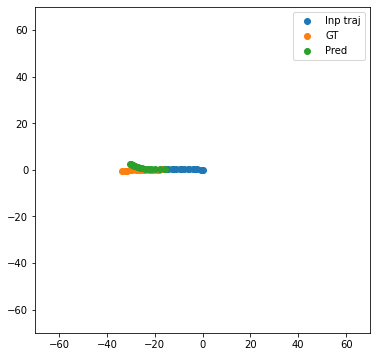

In [39]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, b_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
        for i in range(traj_inp.size()[0]):
            plot_traj(cnt, traj_inp[i], traj_out[i], out[i])
            cnt += 1

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))

In [38]:
for batch_num, data in enumerate(test_loader):
    traj_inp, traj_out, b_inp = data
    print(torch.min(traj_out[:, :16]), torch.max(traj_out[:, :16]))
    print(torch.min(traj_out[:, 16:]), torch.max(traj_out[:, 16:]))
    print("-"*50)

tensor(-46.7178, dtype=torch.float64) tensor(62.6992, dtype=torch.float64)
tensor(-26.2152, dtype=torch.float64) tensor(44.4970, dtype=torch.float64)
--------------------------------------------------
tensor(-36.6545, dtype=torch.float64) tensor(63.4261, dtype=torch.float64)
tensor(-1.7120, dtype=torch.float64) tensor(42.3743, dtype=torch.float64)
--------------------------------------------------
tensor(-49.7683, dtype=torch.float64) tensor(52.1871, dtype=torch.float64)
tensor(-25.4938, dtype=torch.float64) tensor(11.5286, dtype=torch.float64)
--------------------------------------------------
tensor(-42.9790, dtype=torch.float64) tensor(59.2054, dtype=torch.float64)
tensor(-25.9373, dtype=torch.float64) tensor(35.7427, dtype=torch.float64)
--------------------------------------------------
tensor(-43.4078, dtype=torch.float64) tensor(61.7158, dtype=torch.float64)
tensor(-19.8665, dtype=torch.float64) tensor(43.9492, dtype=torch.float64)
-----------------------------------------------